In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import operator

from nltk.corpus import stopwords
stop = stopwords.words('english')

import string
from string import digits
punctuation = string.punctuation

from pandasql import sqldf

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

/Users/sherryguo/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Overview of database

In [2]:
#import data
df_list=pd.read_csv('listings.csv')
df_review=pd.read_csv('reviews.csv',parse_dates=['date'])
df_cal=pd.read_csv('calendar.csv',parse_dates=['date'])

/Users/sherryguo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


## 1.1 Listing

There are 45053 unique listings in LA. 

In [3]:
unique_listing=df_list.id.nunique()
print(unique_listing)

45053


The recorded prices start from 2019-09-14 and end at 2020-09-12

In [14]:
df_cal['date'].max(),df_cal['date'].min()

('2020-09-12', '2019-09-14')

## 1.2 Host

There are 26286 unique hosts in LA in total.

In [5]:
print(df_list.host_id.nunique())

26286


On average, each host has 12 listings.  
The maximum and minimum number of listings per host is 29584 and 1.  
The number of listings per host varies a lot. 

In [6]:
df_2=df_list.groupby(by=['host_id'])['calculated_host_listings_count'].sum()
df_2a=df_2.agg([np.mean,np.median,np.std, np.min, np.max])
df_2a

mean         11.932397
median        1.000000
std         242.143721
amin          1.000000
amax      29584.000000
Name: calculated_host_listings_count, dtype: float64

## 1.3 Reviews

There are 1509564 reviews in total.

In [10]:
df_review.shape[0]

1509564

# 2. Analysis of Data Quality

## 2.1 Key Features

In [ ]:
# extract key columns we want to analysis
list_columns=['listing_id','price','room_type','neighbourhood','beds'
              'host_id','calculated_host_listings_count','host_is_superhost','host_verifications',
              'number_of_reviews','reviews_per_month','review_scores_location', 'review_scores_cleanliness','review_scores_rating',
              'zipcode','latitude','longitude']
df_list=df_list[list_columns]

## 2.2 Missing Data

In [21]:
#find all missing data
miss_listings = df_list.isnull()
miss_cal=df_cal.isnull()
miss_review=df_review.isnull()
print(miss_listings.shape[0],miss_cal.shape[0],miss_review.shape[0])

45053 16444345 1509564


In [20]:
miss_listings.sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               6
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               8519
Length: 106, dtype: int64

In [23]:
#remove all columns with more than 50% missing values
miss_50=df_list.columns[miss_listings.sum()/len(df_list)>0.5]
df_list=df_list.drop(miss_50,axis=1)

#fill other missing values
df_list.fillna(0,inplace=True)

In [24]:
miss_50

Index(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate',
       'neighbourhood_group_cleansed', 'square_feet', 'weekly_price',
       'monthly_price', 'license'],
      dtype='object')

## 2.2 Data Transforming

In [122]:
#price: in string format; transform into float values
def getmoney(price):
    str_pri=str(price)
    str_price=str_pri.replace(",","").strip('$')
    num_price=float(str_price)
    return num_price
df_list['price']=df_list['price'].apply(getmoney)
df_cal['price']=df_cal['price'].apply(getmoney)

In [ ]:
#comments: only select comments in English


In [ ]:
# Boolean types are replaced with a 0 or 1
def repl_f_t(l):
    l = l.replace('f', 0);
    l = l.replace('t', 1);
    return l

In [ ]:
#date
df_cal['date']=df_cal['date'].dt.date
df_review['date']=df_review['date'].dt.date

# 3. Exploratory Data Analysis

## 3.1 Spatial Data Analysis

## 3.2 Price and D&S

1) Price of listing

In [123]:
# Analysis of the average price of a listing in Los Angles
df_6=df_cal.groupby(by=['listing_id'])['price'].mean().agg([np.max,np.min,np.mean,np.std])
round(df_6,4)

amax    25000.0000
amin       10.0274
mean      218.0288
std       580.2143
Name: price, dtype: float64

In [124]:
df_6b=df_cal.groupby(by=['date'])['price'].mean()
df_6b=pd.DataFrame(data=df_6b, columns=['price']).reset_index()

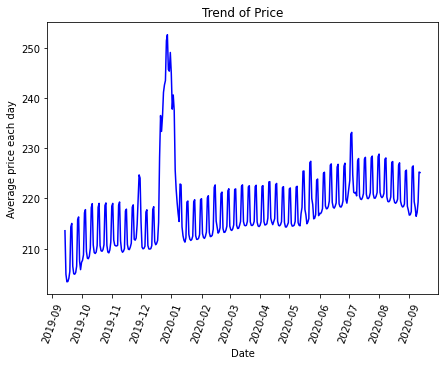

In [134]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(df_6b.date,df_6b.price,color='b')
ax.set(title = "Trend of Price", xlabel="Date", ylabel="Average price each day")
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=70)
plt.show()

In [48]:
# Analysis of the average price of a listing in Los Angles from 01/01/2020 to 03/01/2020 (inclusive)
df_6a=df_cal.loc[(df_cal.date>='2020-01-01') & (df_cal.date<='2020-03-01') &\
                 (df_cal.available=='t'), :]

df_6=df_6a.groupby(by=['listing_id'])['price'].mean().agg([np.max,np.min,np.mean,np.std])
round(df_6,4)

amax    25000.0000
amin       10.1475
mean      254.7782
std       684.7550
Name: price, dtype: float64

2) The number of reviews 

3) Changes of number of listing  
Number of listing did not change.

In [138]:
df_6c=df_cal.groupby(by=['date'])['listing_id'].nunique().agg([np.max,np.min,np.mean,np.std])
df_6c

amax    45053.0
amin    45053.0
mean    45053.0
std         0.0
Name: listing_id, dtype: float64

## 3.3 Host Data Analysis

1) What makes someone a superhost?

For super host, the average number of listings is 7.359 with a standard deviation of 20.867. For non-super host, the average number of listings is 6.795 with a standard deviation of 14.348.

In [15]:
df_3=df_list.groupby(by=['host_is_superhost'])['calculated_host_listings_count'].agg([np.mean,np.std])
df_3.reset_index(inplace=True)
df_3

,host_is_superhost,mean,std
0,f,6.795214,14.348464
1,t,7.359444,20.866644


2) What are the types of host verifications?

There are 22 unique types of host veriftication in LA rental market.  
The top 5 popular types are phone, email, reviews, government_id and offline_government_id

In [4]:
#unique types of verification and the total number of hosts verify that type
d={}
count=0
for i in range(len(df_list)):
    a=df_list["host_verifications"][i].strip("[").strip("]").replace(' ', '').split(",")
    for j in range(len(a)):
        if a[j] in d:
            d[a[j]]+=1
        else:
            d[a[j]]=1
    count+=len(a)

len(d)
d

{"'email'": 42359,
 "'phone'": 44881,
 "'facebook'": 8430,
 "'reviews'": 32907,
 "'kba'": 10762,
 "'jumio'": 20670,
 "'government_id'": 28789,
 "'offline_government_id'": 20906,
 "'selfie'": 13362,
 "'identity_manual'": 12284,
 "'work_email'": 6296,
 "'manual_online'": 307,
 "'manual_offline'": 611,
 "'google'": 3416,
 '': 7,
 "'sent_id'": 144,
 'None': 16,
 "'sesame'": 42,
 "'sesame_offline'": 42,
 "'photographer'": 3,
 "'zhima_selfie'": 181,
 "'weibo'": 78}

In [5]:
#popular verification types and the percent of hosts verify that type
for name in d.keys():
    precent=d[name]/count
    d[name]=round(precent,4)

sorted_d = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
sorted_d

[("'phone'", 0.1821),
 ("'email'", 0.1718),
 ("'reviews'", 0.1335),
 ("'government_id'", 0.1168),
 ("'offline_government_id'", 0.0848),
 ("'jumio'", 0.0839),
 ("'selfie'", 0.0542),
 ("'identity_manual'", 0.0498),
 ("'kba'", 0.0437),
 ("'facebook'", 0.0342),
 ("'work_email'", 0.0255),
 ("'google'", 0.0139),
 ("'manual_offline'", 0.0025),
 ("'manual_online'", 0.0012),
 ("'zhima_selfie'", 0.0007),
 ("'sent_id'", 0.0006),
 ("'weibo'", 0.0003),
 ("'sesame'", 0.0002),
 ("'sesame_offline'", 0.0002),
 ('None', 0.0001),
 ('', 0.0),
 ("'photographer'", 0.0)]

## 3.4 User Reviews Analysis

# 4. Conclusions